# L2RPN Neurips 2020 Track1 SMALL environment

In [1]:
import pathlib
from pprint import pprint

#### Set the paths for data and cofiguration file

In [2]:
LIPS_PATH = pathlib.Path().resolve().parent
DATA_PATH = LIPS_PATH / "reference_data" / "l2rpn_neurips_2020_track1_small"
LOG_PATH = LIPS_PATH / "lips_logs_neurips.log"
CONFIG_PATH = LIPS_PATH / "lips" / "config" / "conf_nips_track1.ini"

Create the path for this environment

In [3]:
if not DATA_PATH.exists():
    DATA_PATH.mkdir(mode=511, parents=False)

## Benchmark1

In [4]:
from lips.benchmark import PowerGridBenchmark
benchmark1 = PowerGridBenchmark(benchmark_path=DATA_PATH,
                                benchmark_name="Benchmark1",
                                load_data_set=False,
                                config_path=CONFIG_PATH, # opt for default config path (benchmark/config.ini)
                                log_path=LOG_PATH)

2022-05-03 13:44:24.571138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 13:44:24.571236: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
benchmark1.generate(nb_sample_train=int(1e5),
                    nb_sample_val=int(1e4),
                    nb_sample_test=int(1e4),
                    nb_sample_test_ood_topo=int(1e4),
                   )

test_ood_topo: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:11<00:00, 10.30it/s]


# Visualization 

In [6]:
from grid2op.PlotGrid import PlotMatplot
def visualize_obs(env, obs):
    plot_helper = PlotMatplot(env.observation_space)
    fig_custom = plot_helper.plot_obs(obs,
                                      line_info="rho",
                                      load_info=None,  # i don't plot anything concerning the load
                                      gen_info="v"  # i draw the voltage setpoint of the generators
                                      )

## Benchmark1

In [6]:
benchmark1._fills_actor_simulator()

/home/milad/environments/lips/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
/home/milad/environments/lips/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
/home/milad/environments/lips/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."
/home/milad/environments/lips/lib/python3.8

### Training scenarios

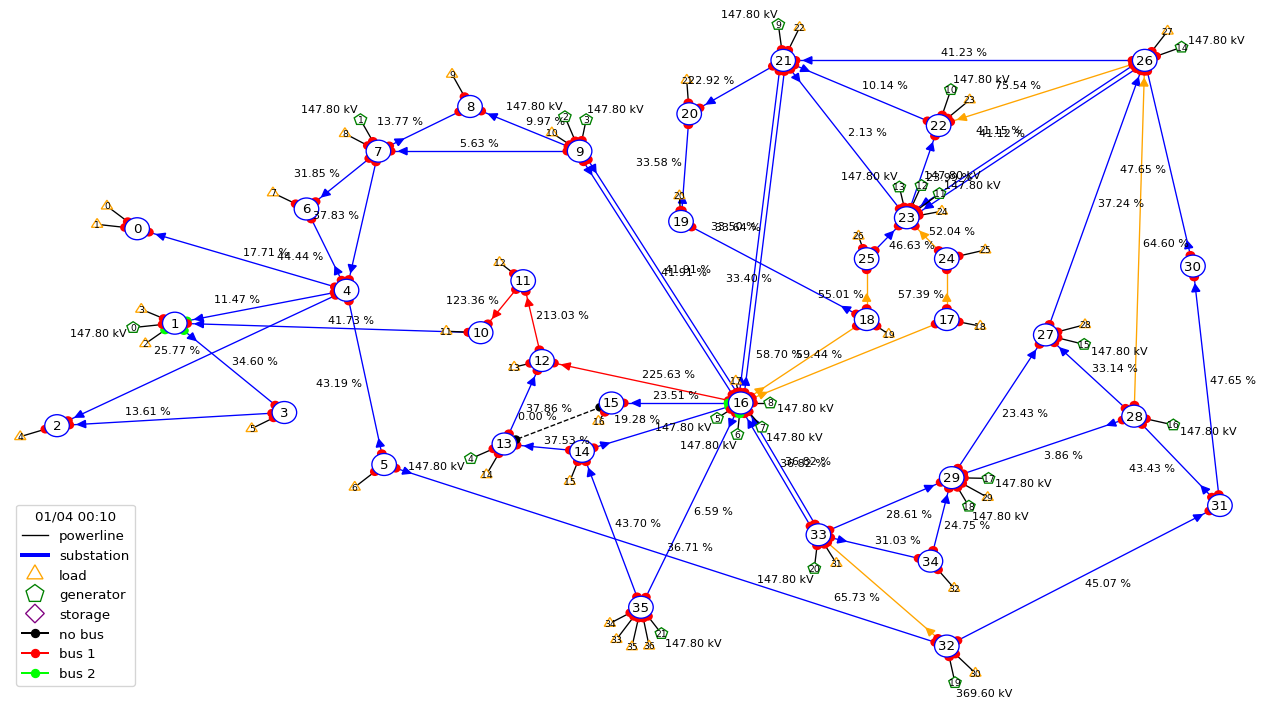

In [7]:
obs = benchmark1.env.reset()
action = benchmark1.training_actor.act(obs)
obs, *_ = benchmark1.env.step(action)
visualize_obs(benchmark1.env, obs)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force disconnection of 1 powerlines ([3])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Disconnect the following element(s):
	 	 - Disconnect line (origin) id 3 [on substation 1]
	 	 - Disconnect line (extremity) id 3 [on substation 3]


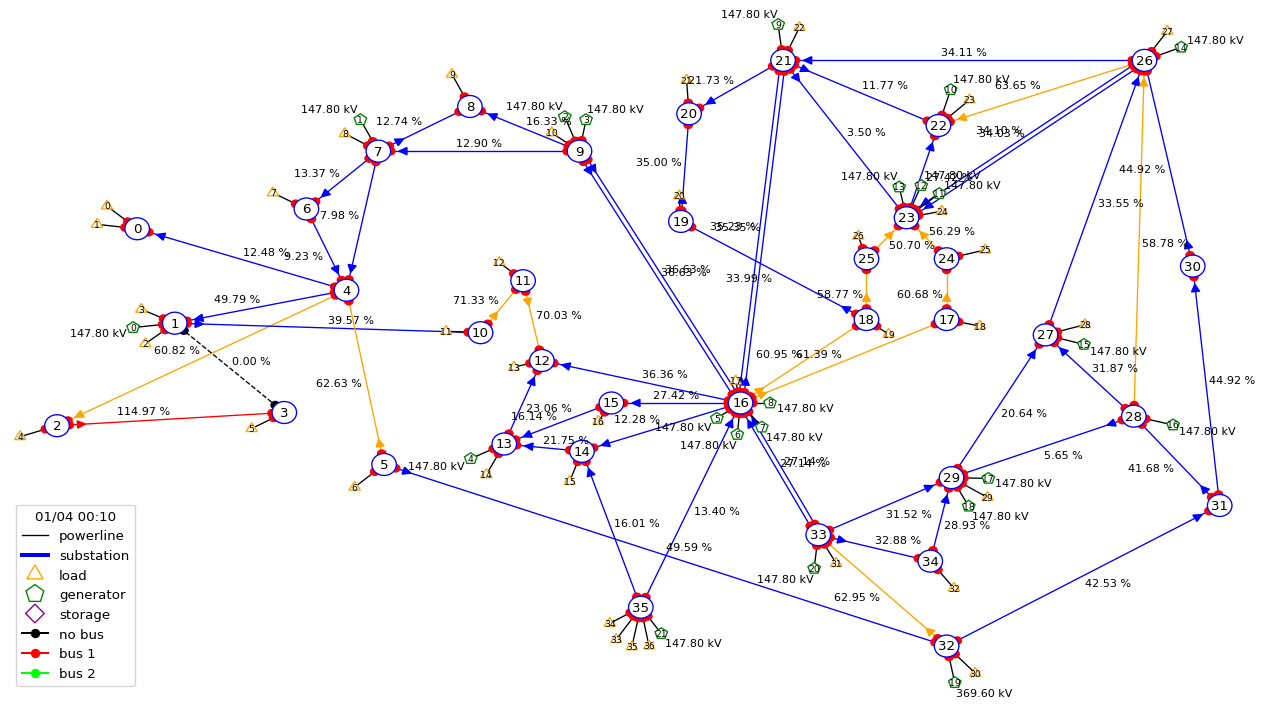

In [24]:
obs = benchmark1.env.reset()
action = benchmark1.training_actor.act(obs)
obs, reward, done, info = benchmark1.env.step(action)
visualize_obs(benchmark1.env, obs)
print(action)

### Test scenarios
There is always one power line disconnected at random. 

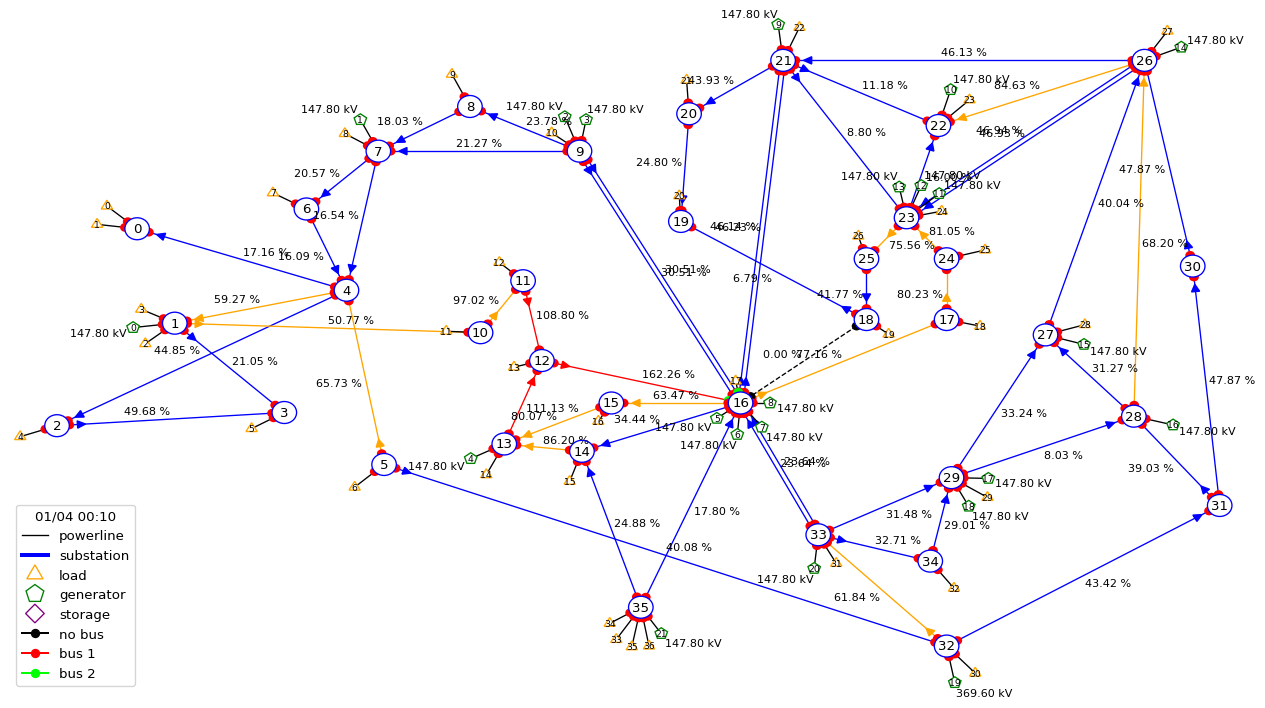

In [15]:
obs = benchmark1.env.reset()
action = benchmark1.test_actor.act(obs)
obs, *_ = benchmark1.env.step(action)
visualize_obs(benchmark1.env, obs)

### Test OOD Generalization
There are always two power lines disconnected at random.

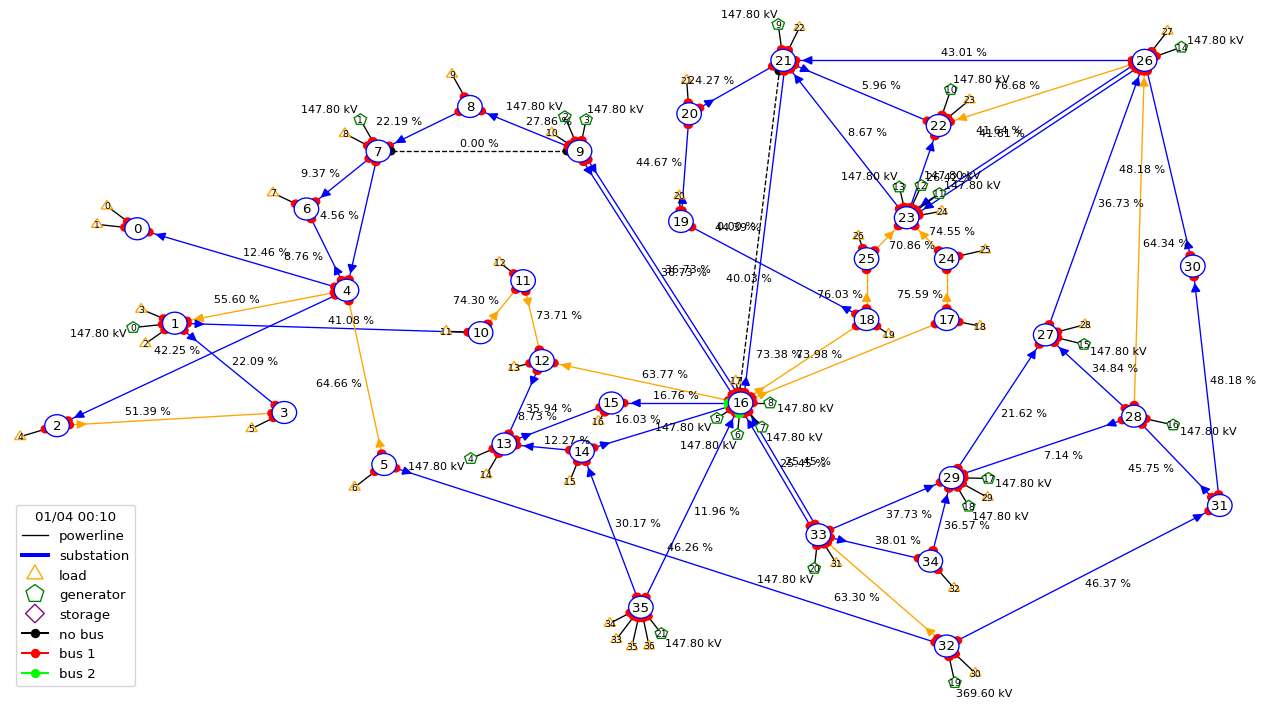

In [8]:
obs = benchmark1.env.reset()
action = benchmark1.test_ood_topo_actor.act(obs)
obs, *_ = benchmark1.env.step(action)
visualize_obs(benchmark1.env, obs)

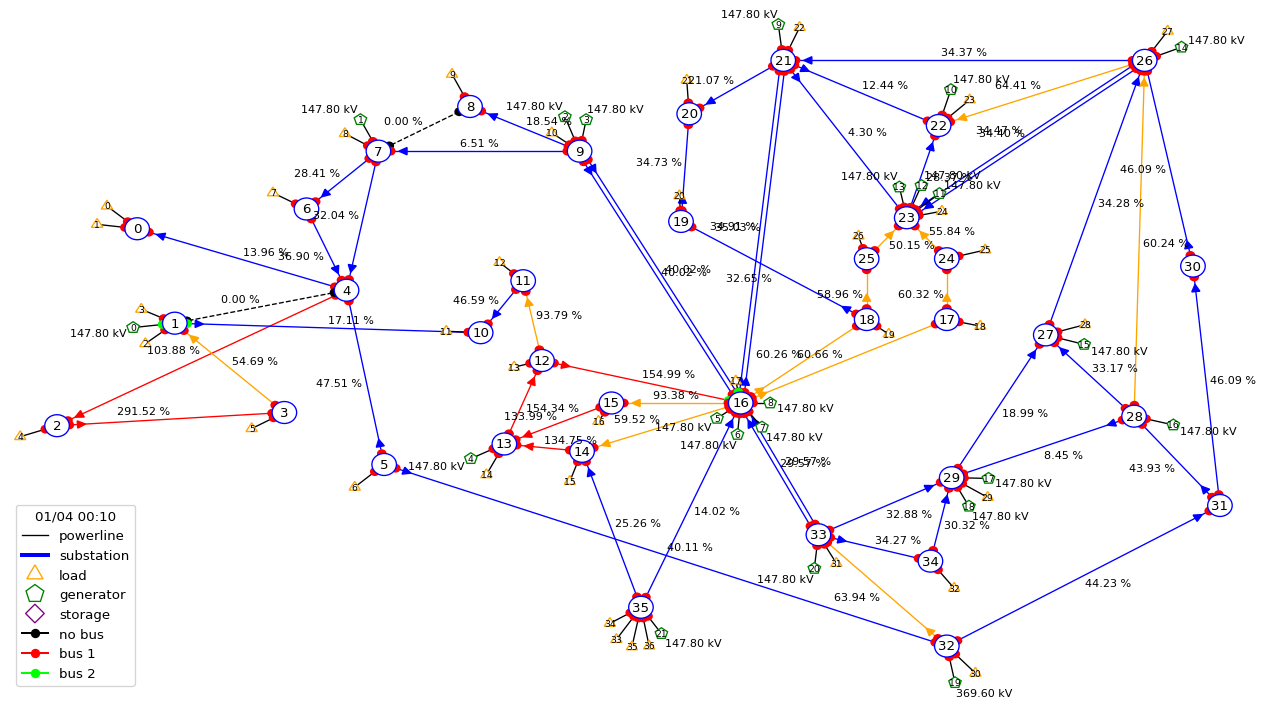

In [16]:
obs = benchmark1.env.reset()
action = benchmark1.test_ood_topo_actor.act(obs)
obs, *_ = benchmark1.env.step(action)
visualize_obs(benchmark1.env, obs)

### Verfiy the chronics  (for debugging purpose, to be removed in future)

In [7]:
import re
import grid2op

In [8]:
env_nips = grid2op.make("l2rpn_neurips_2020_track1_small")

In [9]:
chronics_train_selected_regex="^((?!(.*[3-4][0-9].*)).)*$"
chronics_val_selected_regex=".*3[0-5].*"
chronics_test_selected_regex=".*3[5-9].*"
chronics_test_ood_selected_regex=".*4[0-9].*"
chronics_selected_regex = re.compile(chronics_train_selected_regex)
chronics = lambda path: re.match(chronics_selected_regex, path) is not None

In [ ]:
env_nips.chronics_handler.set_filter(chronics)
env_nips.chronics_handler.real_data.reset()

# Test (to be removed in future)

In [ ]:
benchmark1._fills_actor_simulator()

In [ ]:
benchmark1.training_actor.reference_args

In [150]:
len(benchmark1.training_actor.topo_actions)

36

In [151]:
len(benchmark1.training_actor.ref_agent.topo_actions)

36

In [ ]:
benchmark1.training_actor.ref_agent.topo_actions

In [7]:
obs = benchmark1.env.reset()

In [ ]:
action = benchmark1.training_actor.act(obs)
print(action)

In [ ]:
from lips.benchmark.utils.powergrid_utils import XDepthAgent
from lips.config import ConfigManager
import numpy as np

In [ ]:
config = ConfigManager("Benchmark1", path=CONFIG_PATH)
env = benchmark1.env

In [ ]:
for i, action in enumerate(config.get_option("dataset_create_params")["reference_args"].get("topo_actions")):
    # print(i)
    action = env.action_space(action)
    impacted_sub = int(np.where(action.get_topological_impact()[1])[0])
    print(impacted_sub)

# Debug the errors

In [20]:
env = benchmark1.env
obs = env.reset()

In [15]:
env.reactivate_forecast()

In [ ]:
nb_divergence = 0
for i in range(int(1e5)):
    print(i)
    done = True
    obs = env.reset()
    while done:
        action = benchmark1.training_actor.act(obs)
        obs, reward, done, info = obs.simulate(action)
        
        if info["is_illegal"]:
            print(action)
            print(info)
            raise RuntimeError("Your `actor` should not take illegal action. Please modify the environment "
                                   "or your actor.")
        if done:
            nb_divergence += 1 